# In this notebook a sensitivity analysis will be performed. The best Automatic Trader will be tested with unseen symbols, retraining in the train period, and tested in the Test dataset.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool
import pickle

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
def show_results(results_list, data_in_df, symbol, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = symbol
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's get some "good" symbols (low missing data)

In [3]:
raw_data_df = pd.read_pickle('../../data/data_df.pkl')

In [4]:
close_df = raw_data_df.unstack().loc[:,(slice(None), 'Close')]
close_df.columns = close_df.columns.droplevel('feature')
missing_df = close_df.isnull().sum() / close_df.shape[0]
good_close = list(close_df.loc[:,missing_df < 0.001].columns)
len(good_close)

279

In [5]:
volume_df = raw_data_df.unstack().loc[:,(slice(None), 'Volume')]
volume_df.columns = volume_df.columns.droplevel('feature')
missing_df = volume_df.isnull().sum() / volume_df.shape[0]
good_volume = list(volume_df.loc[:,missing_df < 0.001].columns)
len(good_volume)

279

In [6]:
good_symbols = list(set(good_close).intersection(good_volume))
good_symbols

['CSX',
 'DTE',
 'OKE',
 'EOG',
 'NSC',
 'HD',
 'BBY',
 'JNJ',
 'AJG',
 'EIX',
 'RF',
 'EFX',
 'GLW',
 'JWN',
 'PAYX',
 'EMR',
 'UNM',
 'CNP',
 'CHD',
 'ORCL',
 'SYY',
 'CAH',
 'TMO',
 'AZO',
 'HCP',
 'HOLX',
 'AAPL',
 'AIG',
 'MSFT',
 'ADBE',
 'FOXA',
 'COST',
 'VFC',
 'FISV',
 'CHK',
 'JEC',
 'NEM',
 'CLX',
 'TWX',
 'VMC',
 'MKC',
 'SPLS',
 'TGNA',
 'ALK',
 'LEN',
 'MOS',
 'AXP',
 'LEG',
 'BMY',
 'TMK',
 'LRCX',
 'EXC',
 'UHS',
 'WDC',
 'ZION',
 'PCG',
 'ITW',
 'CELG',
 'EQT',
 'PBCT',
 'FOX',
 'SCG',
 'M',
 'WMT',
 'WFM',
 'PDCO',
 'FDX',
 'PCAR',
 'PPG',
 'RHI',
 'XRX',
 'DOW',
 'TSS',
 'AES',
 'T',
 'IPG',
 'JBHT',
 'AN',
 'MCD',
 'MRK',
 'PH',
 'AET',
 'CINF',
 'APA',
 'BF.B',
 'NUE',
 'UNH',
 'MUR',
 'XEL',
 'LNC',
 'ROK',
 'BCR',
 'CVS',
 'TIF',
 'PNC',
 'BDX',
 'MMC',
 'ROP',
 'DOV',
 'CMI',
 'BAX',
 'MMM',
 'GPS',
 'SNPS',
 'KIM',
 'HOG',
 'BK',
 'HAS',
 'IR',
 'OXY',
 'GWW',
 'PGR',
 'SWKS',
 'SYK',
 'UNP',
 'FMC',
 'AMGN',
 'LUK',
 'FAST',
 'PPL',
 'CERN',
 'IDXX',
 'KLAC',

In [7]:
'SPY' in good_symbols

True

In [8]:
good_symbols.remove('SPY')
'SPY' in good_symbols

False

## Let's test it with n_syms random symbols

In [9]:
n_syms = 20

STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the global data
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')

np.random.seed(2017)
random_symbols = np.random.choice(good_symbols, size=n_syms, replace=False)
# random_symbols = ['SPY'] # debugging
print('Testing with these symbols:\n{}'.format(random_symbols))

# Results holder
results_df = pd.DataFrame(columns=['sharpe', 
                                   'sharpe_bench', 
                                   'cum_ret', 
                                   'cum_ret_bench', 
                                   'sharpe_quotient', 
                                   'cum_ret_quotient',])

for symbol in random_symbols:
    # Set the environment
    data_train_df = total_data_train_df[symbol].unstack()
    data_test_df = total_data_test_df[symbol].unstack()
    data_in_df = data_train_df
    env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  symbol, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
    # Create the Agent
    agent = Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.9999,
                dyna_iterations=0,
                name='Agent_0')
    
    # Train
    print('Training: {}'.format(symbol))
    n_epochs = 7

    for i in range(n_epochs):
        tic = time()
        env.reset(STARTING_DAYS_AHEAD)
        results_list = sim.simulate_period(total_data_train_df, 
                                           symbol,
                                           agent,
                                           starting_days_ahead=STARTING_DAYS_AHEAD,
                                           possible_fractions=POSSIBLE_FRACTIONS,
                                           verbose=False,
                                           other_env=env)
        toc = time()
        print('Epoch: {}'.format(i))
        print('Elapsed time: {} seconds.'.format((toc-tic)))
        print('Random Actions Rate: {}'.format(agent.random_actions_rate))
        show_results([results_list], data_in_df, symbol)
    
    
    # Test
    print('-'*100)
    print('Testing: {}'.format(symbol))
    TEST_DAYS_AHEAD = 20
    env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
    tic = time()
    results_list = sim.simulate_period(total_data_test_df, 
                                    symbol,
                                    agent,
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
    toc = time()
    
    # Show results
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agent.random_actions_rate))
    show_results([results_list], data_test_df, symbol, graph=False)
    print('-'*100)
    
    # Save some results
    total_value = results_list.sum(axis=1)
    sharpe, cumret, _, _, _ = value_eval(pd.DataFrame(total_value))
    sharpe_bench, cumret_bench, _, _, _ = value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))
    sharpe_q = sharpe / sharpe_bench
    cumret_q = cumret / cumret_bench
    results_df = results_df.append(pd.DataFrame({symbol: {'sharpe': sharpe,
                                         'sharpe_bench': sharpe_bench,
                                         'cum_ret': cumret,
                                         'cum_ret_bench': cumret_bench,
                                         'sharpe_quotient': sharpe_q,
                                         'cum_ret_quotient': cumret_q}}).T)

Testing with these symbols:
['BCR' 'CERN' 'DHI' 'ALK' 'GE' 'PCG' 'SRE' 'VZ' 'KMB' 'STT' 'CA' 'IBM'
 'COG' 'RJF' 'SWKS' 'VLO' 'CAT' 'HD' 'FMC' 'EFX']
Training: BCR
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3393588066101074s.  Value: 15340.559999999985..Epoch: 0
Elapsed time: 164.03134417533875 seconds.
Random Actions Rate: 0.5787243211477068
Sharpe ratio: 0.2004941795235722
Cum. Ret.: 0.5084959999999987
AVG_DRET: 0.0001383111767000226
STD_DRET: 0.010951050388351478
Final value: 15084.959999999988
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.34416961669921875s.  Value: 175071.85000000018.Epoch: 1
Elapsed time: 156.78265380859375 seconds.
Random Actions Rate: 0.3417569794774213
Sharpe ratio

In [10]:
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient
BCR,0.060803,0.320985,0.189426,0.453472,0.842292,0.538379
CERN,-0.018543,-0.290124,0.063914,-0.050918,-0.589201,0.086419
DHI,-0.098232,0.099799,-0.984300,-0.366551,0.316697,-1.157418
ALK,-0.107467,0.318033,-0.337911,-0.275229,0.627140,-0.438864
GE,0.104184,0.305246,0.341312,0.688784,0.794915,0.866488
PCG,-0.026200,0.036500,-0.717807,-0.134794,0.193712,-0.695845
SRE,-0.034402,-0.110797,0.310496,-0.118738,-0.209948,0.565558
VZ,-0.031255,0.136228,-0.229431,-0.166705,0.497664,-0.334974
KMB,0.018532,0.036418,0.508867,0.149453,0.195819,0.763220
STT,0.101500,0.064949,1.562757,0.472371,0.257145,1.836981


In [11]:
results_df['sharpe_delta'] = results_df['sharpe'] - results_df['sharpe_bench']
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient,sharpe_delta
BCR,0.060803,0.320985,0.189426,0.453472,0.842292,0.538379,-0.388820
CERN,-0.018543,-0.290124,0.063914,-0.050918,-0.589201,0.086419,0.538282
DHI,-0.098232,0.099799,-0.984300,-0.366551,0.316697,-1.157418,-0.683248
ALK,-0.107467,0.318033,-0.337911,-0.275229,0.627140,-0.438864,-0.902369
GE,0.104184,0.305246,0.341312,0.688784,0.794915,0.866488,-0.106130
PCG,-0.026200,0.036500,-0.717807,-0.134794,0.193712,-0.695845,-0.328506
SRE,-0.034402,-0.110797,0.310496,-0.118738,-0.209948,0.565558,0.091210
VZ,-0.031255,0.136228,-0.229431,-0.166705,0.497664,-0.334974,-0.664369
KMB,0.018532,0.036418,0.508867,0.149453,0.195819,0.763220,-0.046366
STT,0.101500,0.064949,1.562757,0.472371,0.257145,1.836981,0.215226


In [12]:
delta = results_df['sharpe_delta']
pd.DataFrame(delta.describe())

,sharpe_delta
count,20.000000
mean,-0.049477
std,0.519187
min,-0.902369
25%,-0.422890
50%,-0.076248
75%,0.251227
max,1.163407


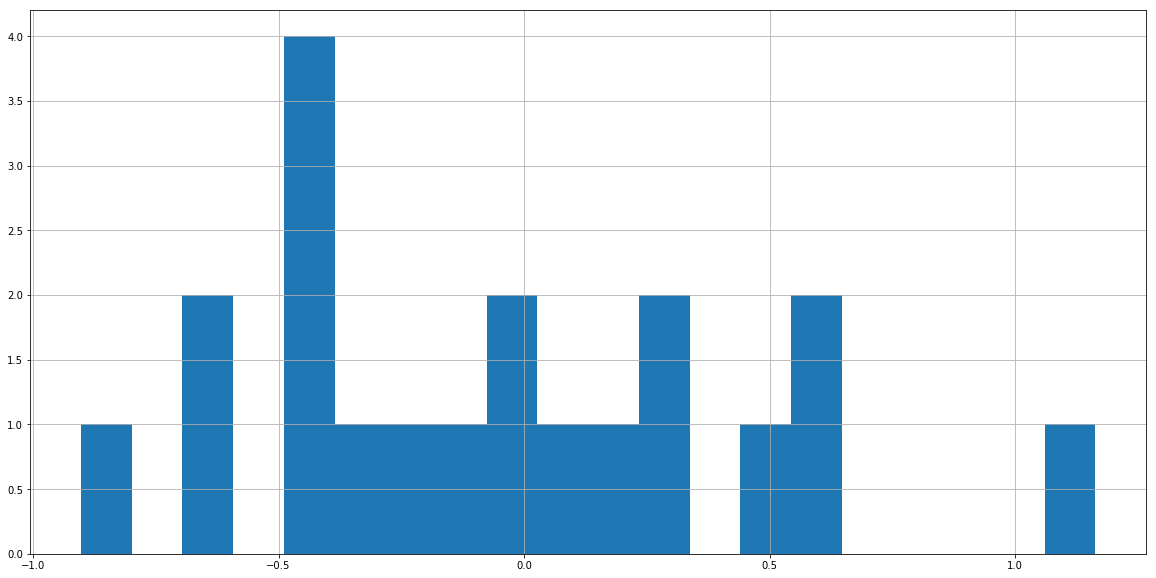

In [13]:
delta.hist(bins=20)